## Goal is to predict or classify Life Expectancy
- We want to first determine which variables are useful

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from statsmodels.tsa.stattools import ccf
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import random
import os

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.model_selection import train_test_split

from scipy.stats import shapiro

pd.set_option('display.float_format', lambda x: '%.4f' % x)
path = "/Users/rishabtirupathi/Desktop/UIUC/Spring 2024/STAT 432/Final Project"
data_raw = pd.read_csv(f"{path}/Life Expectancy Data.csv")
country_list = sorted(list(set((data_raw['Country']))))
data_raw.columns = [i.strip() for i in data_raw.columns]

colours = random.sample(list(mcolors.XKCD_COLORS.keys()), len(country_list))

data_raw.head()

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_69970/2701195088.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0000,263.0000,62,0.0100,71.2796,65.0000,1154,...,6.0000,8.1600,65.0000,0.1000,584.2592,33736494.0000,17.2000,17.3000,0.4790,10.1000
1,Afghanistan,2014,Developing,59.9000,271.0000,64,0.0100,73.5236,62.0000,492,...,58.0000,8.1800,62.0000,0.1000,612.6965,327582.0000,17.5000,17.5000,0.4760,10.0000
2,Afghanistan,2013,Developing,59.9000,268.0000,66,0.0100,73.2192,64.0000,430,...,62.0000,8.1300,64.0000,0.1000,631.7450,31731688.0000,17.7000,17.7000,0.4700,9.9000
3,Afghanistan,2012,Developing,59.5000,272.0000,69,0.0100,78.1842,67.0000,2787,...,67.0000,8.5200,67.0000,0.1000,669.9590,3696958.0000,17.9000,18.0000,0.4630,9.8000
4,Afghanistan,2011,Developing,59.2000,275.0000,71,0.0100,7.0971,68.0000,3013,...,68.0000,7.8700,68.0000,0.1000,63.5372,2978599.0000,18.2000,18.2000,0.4540,9.5000


#### Data preprocessing
- Determine any missing data, linearly interpolate them
- Use correlation analysis to determine which features to use

/var/folders/68/886mn3q57q9f6lcdshz9b8j80000gn/T/ipykernel_69970/1790033287.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method = 'linear')


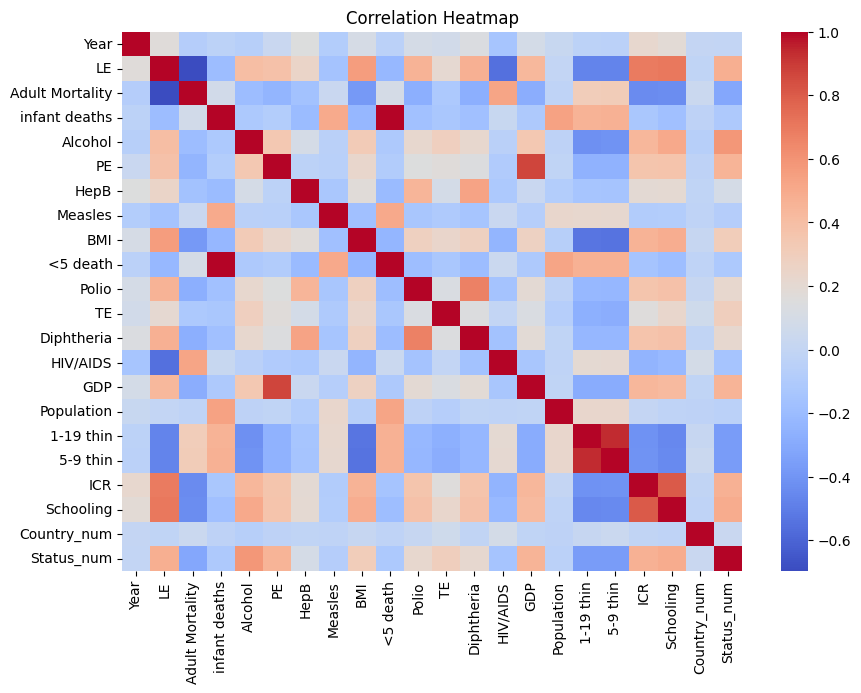

In [13]:
df = data_raw.copy()

## Make categorical variables in quantitative
df['Country_num'] = df['Country'].apply(lambda x: country_list.index(x) + 1)
df['Status_num'] = df['Status'].apply(lambda x: 0 if x == 'Developing' else 1)
df['Colour'] = df['Country'].apply(lambda x: colours[country_list.index(x)])

df = df.interpolate(method = 'linear')

# df.to_csv(f"{path}/Interpolated WHO Data.csv")

corr_df = df.drop(columns=['Country', 'Status', 'Colour'])
corr_df = corr_df.rename(columns = {"Life expectancy": "LE", \
                                    "Income composition of resources": "ICR",
                                    "percentage expenditure": "PE", \
                                    "Hepatitis B": "HepB", \
                                    "under-five deaths": "<5 death", \
                                    "Total expenditure": "TE", \
                                    'thinness 1-19 years': "1-19 thin", \
                                    'thinness 5-9 years': "5-9 thin"}).corr()
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 7))
sns.heatmap(corr_df, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig(f"{path}/Correlation Heatmap")
plt.show()

# ## Consider the values which have |r| high enough (arbitrary)
corr_df = df.drop(columns=['Country', 'Status', 'Colour']).corr()
life_expectancy_corr = pd.DataFrame({"Column": corr_df.loc["Life expectancy"].index, "Correlation": corr_df.loc["Life expectancy"].values})
life_exp_var = life_expectancy_corr[abs(life_expectancy_corr['Correlation']) >= 0.5]
life_exp_var = life_exp_var[life_exp_var['Column'] != 'Life expectancy'].reset_index(drop = True)
pred = list(life_exp_var['Column'])
life_exp_var

#### Create scatter plot to visualise data

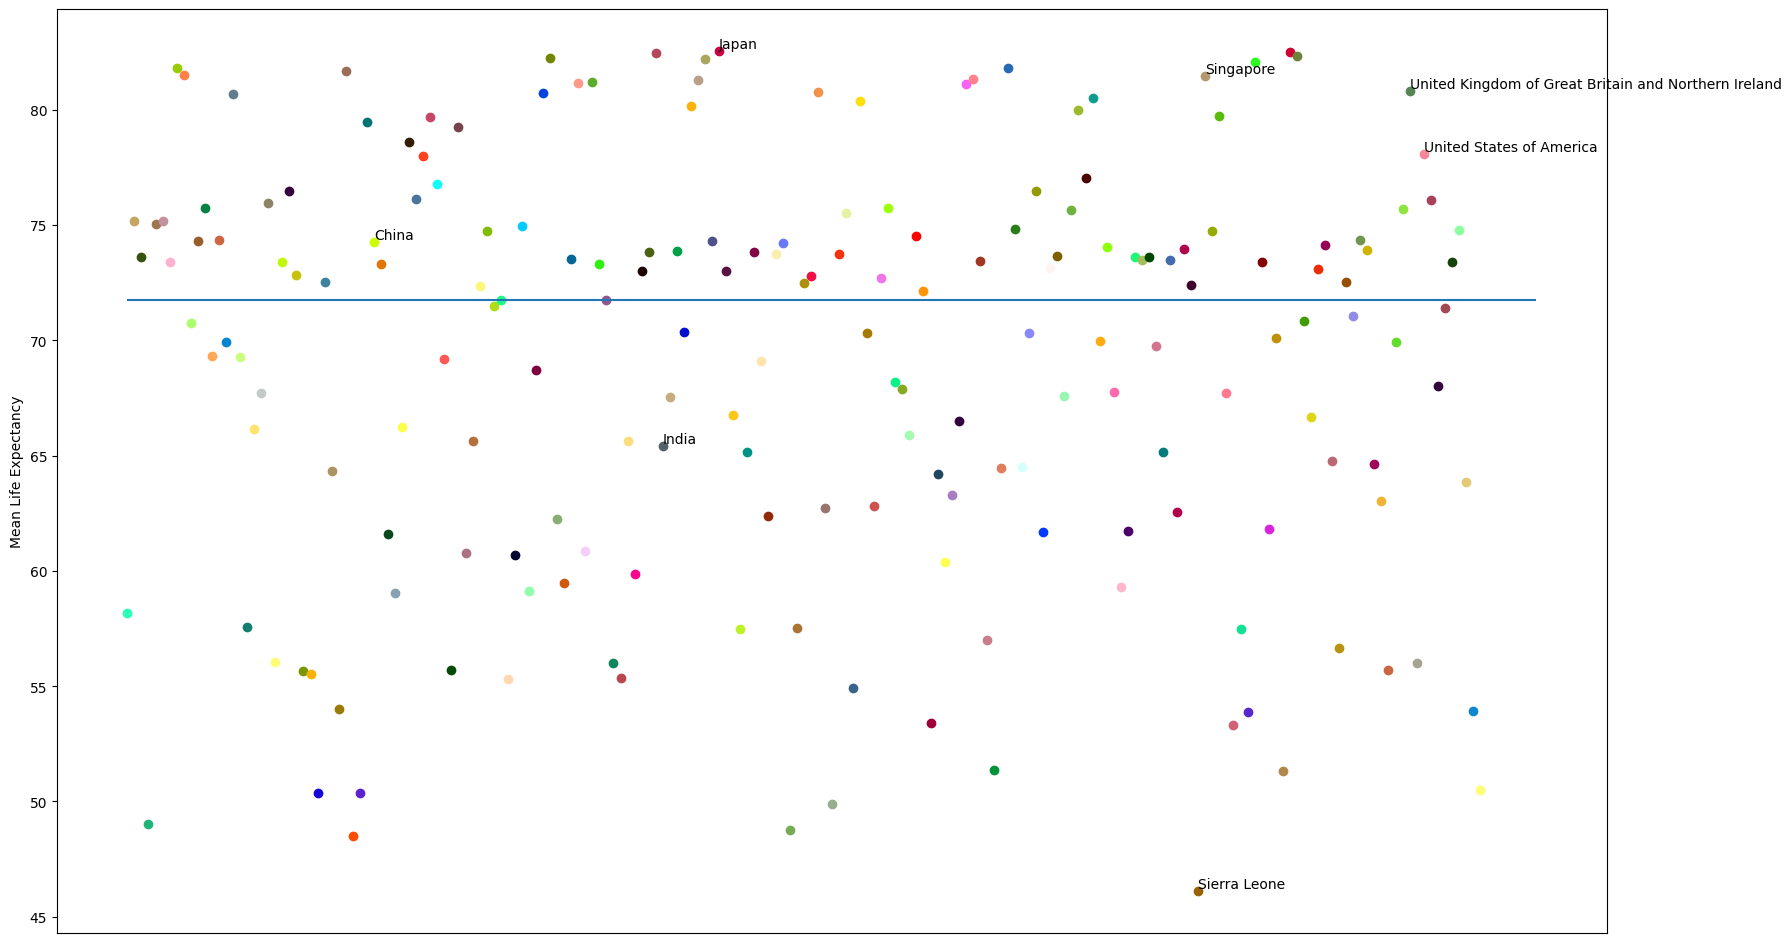

In [3]:
trunc_df = df.copy()
trunc_df['Mean LE'] = trunc_df.groupby(by = 'Country')['Life expectancy'].transform('mean')
trunc_df = trunc_df[['Country', 'Mean LE', 'Colour']].drop_duplicates().reset_index(drop = True)
key_countries = ['United States of America', 'United Kingdom of Great Britain and Northern Ireland', 'Singapore', 'India', 'China']
max_mle = max(trunc_df['Mean LE'])
min_mle = min(trunc_df['Mean LE'])

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (20, 12))
for country, mean_le, colour in zip(trunc_df['Country'], trunc_df['Mean LE'], trunc_df['Colour']):
    axes.scatter(country, mean_le, c = colour, label = country)

    if country in key_countries or mean_le in [max_mle, min_mle]:
        plt.text(country, mean_le, country, va = 'bottom')

axes.set_xticks([])
axes.set_ylabel("Mean Life Expectancy")
axes.hlines(y = trunc_df['Mean LE'].median(), xmin = 0, xmax = 200)
plt.show()

#### Describe life expectancy to determine how to class it
- Mean is less than median, so left skew,
- Large enough to say roughly normal

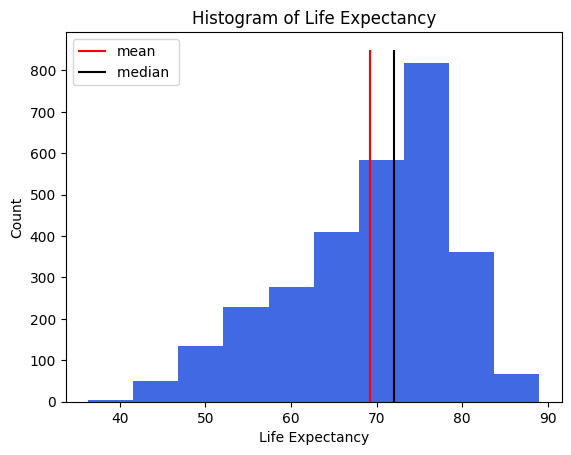

count   2938.0000
mean      69.2149
std        9.5108
min       36.3000
25%       63.1000
50%       72.0000
75%       75.6000
max       89.0000
Name: Life expectancy, dtype: float64

In [40]:
plt.hist(df['Life expectancy'], color='royalblue')
plt.xlabel("Life Expectancy")
plt.ylabel("Count")
plt.title("Histogram of Life Expectancy")
plt.vlines(x = df['Life expectancy'].describe()['mean'], ymin = 0, ymax = 850, colors='red', label = 'mean')
plt.vlines(x = df['Life expectancy'].describe()['50%'], ymin = 0, ymax = 850, colors='black', label = 'median ')
plt.legend()
plt.savefig(f'{path}/Histogram of LE')
plt.show()

df['Life expectancy'].describe()

#### Logistic Regression
- Because Logistic regression is a classification problem, the output needs to be categorical
- Encode life expectancy as <33% (66.5) as low, 33 - 67% (66. 5 - 74.4) as medium, >67% (74.4) as high
- This uses max as the choice of class

Test Classification Error = 0.179
Train Classification Error = 0.205
              precision    recall  f1-score   support

        high       0.83      0.82      0.82       197
         low       0.95      0.85      0.89       189
      medium       0.72      0.80      0.76       202

    accuracy                           0.82       588
   macro avg       0.83      0.82      0.83       588
weighted avg       0.83      0.82      0.82       588



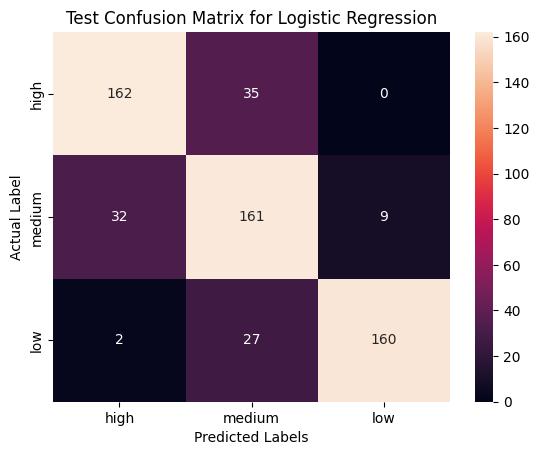

In [29]:
np.random.seed(12)
model_three_df = df.copy()
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize = (6, 4))
three_classes = ['high', 'medium', 'low']

## Split train and test
train_data = pd.read_csv(f"{path}/Training Data.csv").drop(columns = 'Unnamed: 0')
test_data = pd.read_csv(f"{path}/Testing Data.csv").drop(columns = 'Unnamed: 0')

## Bounds for low, medium, high expectancy
q1 = df['Life expectancy'].quantile(1/3)
q2 = df['Life expectancy'].quantile(2/3)

train_data['Life expectancy category'] = train_data['Life expectancy'].apply(lambda x: "low" if x < q1 else("medium" if x <= q2 else "high"))
test_data['Life expectancy category'] = test_data['Life expectancy'].apply(lambda x: "low" if x < q1 else("medium" if x <= q2 else "high"))

#### Create training and testing df
# # train_data, test_data = train_test_split(model_df, train_size=0.8)
# # train_data.to_csv(f"{path}/Training Data.csv")
# # test_data.to_csv(f"{path}/Testing Data.csv")

scaler = StandardScaler()
X_three_train, y_three_train = scaler.fit_transform(train_data[pred]), train_data['Life expectancy category']
X_three_test, y_three_test = scaler.fit_transform(test_data[pred]), test_data['Life expectancy category']

# Construct model
three_log_mod = LogisticRegression(random_state = 4)
three_log_mod.fit(X_three_train, y_three_train)
y_three_pred = three_log_mod.predict(X_three_test)
y_three_train_pred = three_log_mod.predict(X_three_train)

## Combine results in df
three_test_results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_three_pred, "Actual": y_three_test})
three_prob_prediction = three_log_mod.predict_proba(X_three_test)

for i in range(len(three_classes)):
    three_test_results[f'P({three_classes[i]})'] = three_prob_prediction[:, i]
    
three_test_conf_matrix = confusion_matrix(y_true = three_test_results['Actual'], y_pred = three_test_results['Prediction'], labels = three_classes)
sns.heatmap(three_test_conf_matrix, annot = True, fmt = 'g')

plt.xlabel("Predicted Labels")
plt.ylabel("Actual Label")
plt.title("Test Confusion Matrix for Logistic Regression")
plt.xticks(ticks = [0.5, 1.5, 2.5], labels = three_classes)
plt.yticks(ticks = [0.5, 1.5, 2.5], labels = three_classes)
plt.savefig(f"{path}/Confusion Matrix for 3 class")

# three_row_sum = np.sum(three_test_conf_matrix, axis=1)
# three_percent_confusion = three_test_conf_matrix/three_row_sum[:, np.newaxis]
# sns.heatmap(three_percent_confusion, annot = True, fmt = 'g', ax=axes[1])

# axes[1].set_xlabel("Predicted Labels")
# axes[1].set_ylabel("Actual Label")
# axes[1].set_title("Test Confusion Matrix Percentage Reported")
# axes[1].set_xticks(ticks = [0.5, 1.5, 2.5], labels = three_classes)
# axes[1].set_yticks(ticks = [0.5, 1.5, 2.5], labels = three_classes)
# plt.show()

three_test_classification_error = 1-(sum(np.diag(three_test_conf_matrix))/sum(sum(three_test_conf_matrix)))

print("Test Classification Error =", round(1-accuracy_score(y_true = three_test_results['Actual'], y_pred=three_test_results['Prediction']), 3))
print("Train Classification Error =", round(1-accuracy_score(y_true = y_three_train, y_pred=y_three_train_pred), 3))

## Recall = Sensitivity = TP/(TP + FN), Precision = TP/(TP + FP), F1 score = 2 * Precision * Sensitivity/(Precision + Sensitivity), Support = Row Sum
print(classification_report(y_true = y_three_test, y_pred = y_three_pred)) 

##### Run the same model with 2 classes
- Since the life expectancy median is higher than the mean and the spread is smaller, we consider more than a 50-50 split for high and low
- We use a 75-25 high-low split

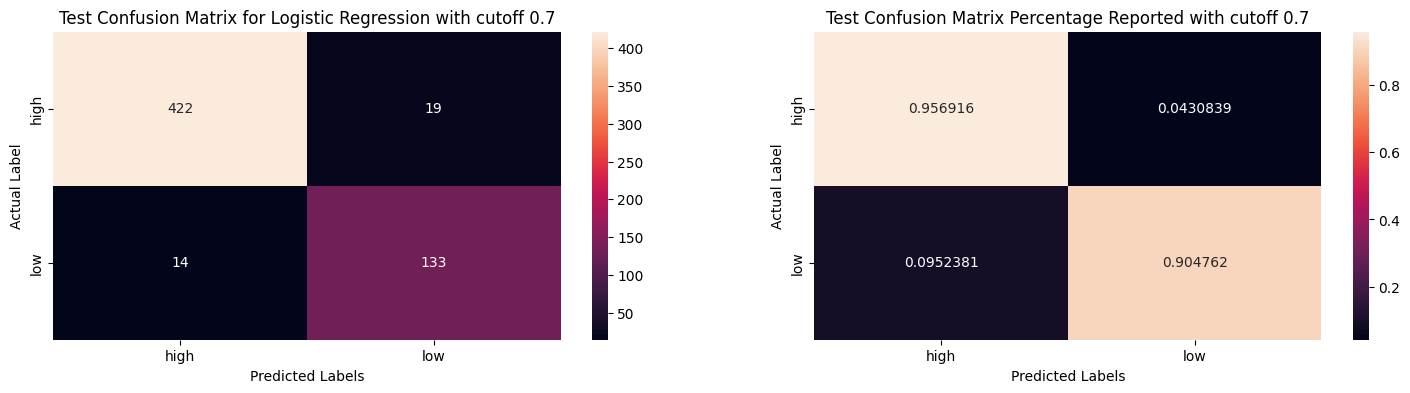

Test Classification Error = 0.056
Train Classification Error = 0.068
              precision    recall  f1-score   support

        high       0.94      0.98      0.96       441
         low       0.91      0.80      0.86       147

    accuracy                           0.93       588
   macro avg       0.93      0.89      0.91       588
weighted avg       0.93      0.93      0.93       588



In [6]:
np.random.seed(12)
model_two_df = df.copy()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (18, 4))
two_classes = ['high', 'low']

## Split train and test
train_data = pd.read_csv(f"{path}/Training Data.csv").drop(columns = 'Unnamed: 0')
test_data = pd.read_csv(f"{path}/Testing Data.csv").drop(columns = 'Unnamed: 0')

## Bounds for low, medium, high expectancy
q1 = df['Life expectancy'].quantile(1/4)

train_data['Life expectancy category'] = train_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")
test_data['Life expectancy category'] = test_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")

#### Create training and testing df
# # train_data, test_data = train_test_split(model_df, train_size=0.8)
# # train_data.to_csv(f"{path}/Training Data.csv")
# # test_data.to_csv(f"{path}/Testing Data.csv")

scaler = StandardScaler()
X_two_train, y_two_train = scaler.fit_transform(train_data[pred]), train_data['Life expectancy category']
X_two_test, y_two_test = scaler.fit_transform(test_data[pred]), test_data['Life expectancy category']

# Construct model
two_log_mod = LogisticRegression(random_state = 4)
two_log_mod.fit(X_two_train, y_two_train)
y_two_pred = two_log_mod.predict(X_two_test)
y_two_train_pred = two_log_mod.predict(X_two_train)

## Combine results in df
two_test_results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_two_pred, "Actual": y_two_test})
two_prob_prediction = two_log_mod.predict_proba(X_two_test)

for i in range(len(two_classes)):
    two_test_results[f'P({two_classes[i]})'] = two_prob_prediction[:, i]

## Create cutoff probability
best_cut = -1
best_test_error = 10**7

for c in range(0, 10, 1):
    cut_off = c/10
    two_test_results['Prediction'] = two_test_results.apply(lambda x: "high" if x['P(high)'] >= cut_off else "low", axis = 1)

    test_conf_matrix = confusion_matrix(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction'], labels = two_classes)
    test_classification_error = 1-(sum(np.diag(test_conf_matrix))/sum(sum(test_conf_matrix)))

    if test_classification_error < best_test_error: 
        best_cut = cut_off
        best_test_error = test_classification_error

# Use best cutoff to determine prediction
two_test_results['Prediction'] = two_test_results.apply(lambda x: "high" if x['P(high)'] >= best_cut else "low", axis = 1)
test_conf_matrix = confusion_matrix(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction'], labels = two_classes)
sns.heatmap(test_conf_matrix, annot = True, fmt = 'g', ax=axes[0])

axes[0].set_xlabel("Predicted Labels")
axes[0].set_ylabel("Actual Label")
axes[0].set_title(f"Test Confusion Matrix for Logistic Regression with cutoff {best_cut}")
axes[0].set_xticks(ticks = [0.5, 1.5], labels = two_classes)
axes[0].set_yticks(ticks = [0.5, 1.5], labels = two_classes)

row_sum = np.sum(test_conf_matrix, axis=1)
percent_confusion = test_conf_matrix/row_sum[:, np.newaxis]
sns.heatmap(percent_confusion, annot = True, fmt = 'g', ax=axes[1])

axes[1].set_xlabel("Predicted Labels")
axes[1].set_ylabel("Actual Label")
axes[1].set_title(f"Test Confusion Matrix Percentage Reported with cutoff {best_cut}")
axes[1].set_xticks(ticks = [0.5, 1.5], labels = two_classes)
axes[1].set_yticks(ticks = [0.5, 1.5], labels = two_classes)
plt.show()

## Calculate metrics
## Recall = Sensitivity = TP/(TP + FN), Precision = TP/(TP + FP), 
## F1 score = 2 * Precision * Sensitivity/(Precision + Sensitivity), Support = Row Sum

train_error = round(1-accuracy_score(y_true = y_two_train, y_pred=y_two_train_pred), 3)
print("Test Classification Error =", round(best_test_error, 3))
print("Train Classification Error =", train_error)
print(classification_report(y_true = y_two_test, y_pred = y_two_pred))

##### Combine the results of the 2-class logistic model
- We show the performance for multiple splits and the output for the best cutoff
- We assume that the positive class is "high"
- We get the following results
    - Lowest Test Error =  0.0442, 0.9-0.1 split, 0.5 cutoff
    
    - Highest Sensitivity =  0.9879, 0.3-0.7 split, 0.5 cutoff

In [7]:
np.random.seed(12)
two_classes = ['high', 'low']

## Create for best metrics
overall_best_test_error = 10**6
best_test_error_q = 0
best_test_cut = 0

best_test_sensitivity = -1
best_test_sense_q = 0
best_test_sense_cut = 0

for q in range(1, 10, 1):
    ## Split train and test
    train_data = pd.read_csv(f"{path}/Training Data.csv").drop(columns = 'Unnamed: 0')
    test_data = pd.read_csv(f"{path}/Testing Data.csv").drop(columns = 'Unnamed: 0')

    ## Bounds for low, medium, high expectancy
    q1 = df['Life expectancy'].quantile(q/10)

    train_data['Life expectancy category'] = train_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")
    test_data['Life expectancy category'] = test_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")

    scaler = StandardScaler()
    X_two_train, y_two_train = scaler.fit_transform(train_data[pred]), train_data['Life expectancy category']
    X_two_test, y_two_test = scaler.fit_transform(test_data[pred]), test_data['Life expectancy category']

    # Construct model
    two_log_mod = LogisticRegression(random_state = 4)
    two_log_mod.fit(X_two_train, y_two_train)
    y_two_pred = two_log_mod.predict(X_two_test)
    y_two_train_pred = two_log_mod.predict(X_two_train)

    ## Combine results in df
    two_test_results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_two_pred, "Actual": y_two_test})
    two_prob_prediction = two_log_mod.predict_proba(X_two_test)

    for i in range(len(two_classes)):
        two_test_results[f'P({two_classes[i]})'] = two_prob_prediction[:, i]

    ## Create cutoff probability
    best_cut = -1
    best_test_error = 10**7

    for c in range(0, 10, 1):
        cut_off = c/10
        two_test_results['Prediction'] = two_test_results.apply(lambda x: "high" if x['P(high)'] >= cut_off else "low", axis = 1)

        test_conf_matrix = confusion_matrix(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction'], labels = two_classes)
        test_classification_error = 1-(sum(np.diag(test_conf_matrix))/sum(sum(test_conf_matrix)))

        if test_classification_error < best_test_error: 
            best_cut = cut_off
            best_test_error = test_classification_error

    # Use best cutoff to determine prediction
    two_test_results['Prediction'] = two_test_results.apply(lambda x: "high" if x['P(high)'] >= best_cut else "low", axis = 1)
    test_conf_matrix = confusion_matrix(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction'], labels = two_classes)

    ## Calculate metrics
    train_error = round(1-accuracy_score(y_true = y_two_train, y_pred=y_two_train_pred), 3)
    sensitivity = test_conf_matrix[0, 0]/(test_conf_matrix[0, 0] + test_conf_matrix[0, 1])
    
    if best_test_error < overall_best_test_error:
        overall_best_test_error = best_test_error
        best_test_error_q = q/10
        best_test_cut = best_cut

    if sensitivity > best_test_sensitivity:
        best_test_sensitivity = sensitivity
        best_test_sense_q = q/10
        best_test_sense_cut = best_cut

print("Lowest Test Error = ", round(overall_best_test_error, 4), "\nBest test split =", best_test_error_q, '\nBest test cutoff =', best_test_cut, end = '\n\n')
print(f"Highest Sensitivity = ", round(best_test_sensitivity, 4), "\nBest test split =", best_test_sense_q, \
          '\nBest test cutoff =', best_test_sense_cut, end = '\n\n')

Lowest Test Error =  0.0442 
Best test split = 0.9 
Best test cutoff = 0.5

Highest Sensitivity =  0.9879 
Best test split = 0.3 
Best test cutoff = 0.5



#### We run the models with the above results to determine which model is better

0.9 79.7
0.9-0.1 split, cutoff = 0.5
Test Classification Error = 0.044
Train Classification Error = 0.048
              precision    recall  f1-score   support

        high       0.87      0.71      0.78        66
         low       0.96      0.99      0.98       522

    accuracy                           0.96       588
   macro avg       0.92      0.85      0.88       588
weighted avg       0.95      0.96      0.95       588

0.3 65.21000000000001
0.3-0.7 split, cutoff = 0.5
Test Classification Error = 0.056
Train Classification Error = 0.07
              precision    recall  f1-score   support

        high       0.94      0.99      0.96       412
         low       0.97      0.84      0.90       176

    accuracy                           0.94       588
   macro avg       0.95      0.91      0.93       588
weighted avg       0.95      0.94      0.94       588

Logistic Regression Equation:
y = -1.053 + (1.358 * Adult Mortality) + (-0.721 * BMI) + (4.285 * HIV/AIDS) + (-0.429 * Inc

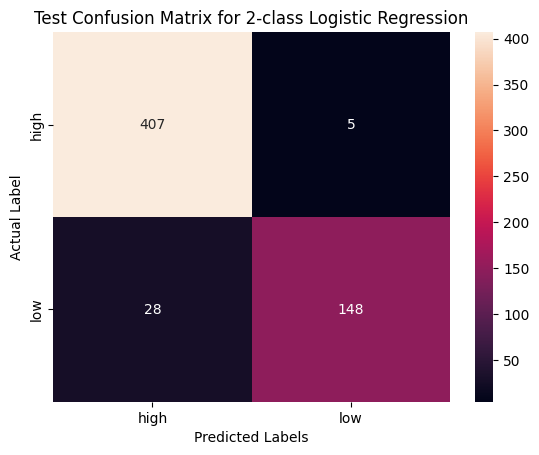

In [46]:
np.random.seed(12)
two_classes = ['high', 'low']
cut_off = 0.5

for q in [0.9, 0.3]:
    ## Split train and test
    train_data = pd.read_csv(f"{path}/Training Data.csv").drop(columns = 'Unnamed: 0')
    test_data = pd.read_csv(f"{path}/Testing Data.csv").drop(columns = 'Unnamed: 0')

    ## Bounds for low, medium, high expectancy
    q1 = df['Life expectancy'].quantile(q)
    print(q, q1)

    train_data['Life expectancy category'] = train_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")
    test_data['Life expectancy category'] = test_data['Life expectancy'].apply(lambda x: "low" if x < q1 else "high")

    scaler = StandardScaler()
    X_two_train, y_two_train = scaler.fit_transform(train_data[pred]), train_data['Life expectancy category']
    X_two_test, y_two_test = scaler.fit_transform(test_data[pred]), test_data['Life expectancy category']

    # Construct model
    two_log_mod = LogisticRegression(random_state = 4)
    two_log_mod.fit(X_two_train, y_two_train)
    y_two_pred = two_log_mod.predict(X_two_test)
    y_two_train_pred = two_log_mod.predict(X_two_train)

    ## Combine results in df
    two_test_results = pd.DataFrame({"Country": test_data['Country'], "Year": test_data['Year'], "Prediction": y_two_pred, \
                                     "Actual": y_two_test, "Actual LE": test_data["Life expectancy"]})
    two_prob_prediction = two_log_mod.predict_proba(X_two_test)

    for i in range(len(two_classes)):
        two_test_results[f'P({two_classes[i]})'] = two_prob_prediction[:, i]

    ## Create cutoff probability
    two_test_results['Prediction'] = two_test_results.apply(lambda x: "high" if x['P(high)'] >= cut_off else "low", axis = 1)
    test_conf_matrix = confusion_matrix(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction'], labels = two_classes)
    test_classification_error = 1-(sum(np.diag(test_conf_matrix))/sum(sum(test_conf_matrix)))

    ## Calculate metrics
    ## Calculate metrics
    ## Recall = Sensitivity = TP/(TP + FN), Precision = TP/(TP + FP), 
    ## F1 score = 2 * Precision * Sensitivity/(Precision + Sensitivity), Support = Row Sum

    train_error = round(1-accuracy_score(y_true = y_two_train, y_pred = y_two_train_pred), 3)
    test_error = round(1-accuracy_score(y_true = two_test_results['Actual'], y_pred = two_test_results['Prediction']), 3)

    print(f"{q}-{round(1-q, 2)} split, cutoff = {cut_off}")
    print("Test Classification Error =", test_error)
    print("Train Classification Error =", train_error)
    print(classification_report(y_true = y_two_test, y_pred = y_two_pred))

    if q == 0.3:
        sns.heatmap(test_conf_matrix, annot = True, fmt = 'g')  
        plt.xlabel("Predicted Labels")
        plt.ylabel("Actual Label")
        plt.title("Test Confusion Matrix for 2-class Logistic Regression")
        plt.xticks(ticks = [0.5, 1.5], labels = two_classes)
        plt.yticks(ticks = [0.5, 1.5], labels = two_classes)
        plt.savefig(f"{path}/Best Confusion Matrix for 2 class")
    
        false_positive = two_test_results[(two_test_results['Actual'] == 'high') & (two_test_results['Prediction'] == 'low')]
        false_negative = two_test_results[(two_test_results['Prediction'] == 'high') & (two_test_results['Actual'] == 'low')]

        # Get the coefficients of the logistic regression model
        coefficients = two_log_mod.coef_

        # Get the intercept of the logistic regression model
        intercept = two_log_mod.intercept_

        # Get the names of the predictor variables
        predictor_names = train_data[pred].columns

        # Print the equation of the logistic regression model
        print("Logistic Regression Equation:")
        equation = "y = " + str(round(intercept[0], 3))
        for i, predictor in enumerate(predictor_names):
            equation += " + (" + str(round(coefficients[0][i], 3)) + " * " + predictor + ")"
        print(equation)
        